In [1]:
!pip install numpy==1.26.4 pmdarima==2.0.4

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
%matplotlib inline
from matplotlib.pylab import rcParams

In [3]:
# Set the default figure size for matplotlib plots to 15 inches wide by 6 inches tall
rcParams["figure.figsize"] = (15, 6)

# Increase the default font size of the titles in matplotlib plots to extra-extra-large
rcParams["axes.titlesize"] = "xx-large"

# Make the titles of axes in matplotlib plots bold for better visibility
rcParams["axes.titleweight"] = "bold"

# Set the default location of the legend in matplotlib plots to the upper left corner
rcParams["legend.loc"] = "upper left"

# Configure pandas to display all columns of a DataFrame when printed to the console
pd.set_option('display.max_columns', None)

# Configure pandas to display all rows of a DataFrame when printed to the console
pd.set_option('display.max_rows', None)

In [4]:
#import dataset
url = "streamflow_filled_ARIMA.csv"
df = pd.read_csv(url)
dftrain = df[df['Year'] != 2017]
dftest = df[df['Year'] == 2017]

<class 'pandas.core.frame.DataFrame'>
Index: 18263 entries, 0 to 18262
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        18263 non-null  object 
 1   Unnamed: 0  18263 non-null  int64  
 2   Year        18263 non-null  int64  
 3   Month       18263 non-null  int64  
 4   Day         18263 non-null  int64  
 5   Q (m3/s)    18263 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 998.8+ KB


<Axes: >

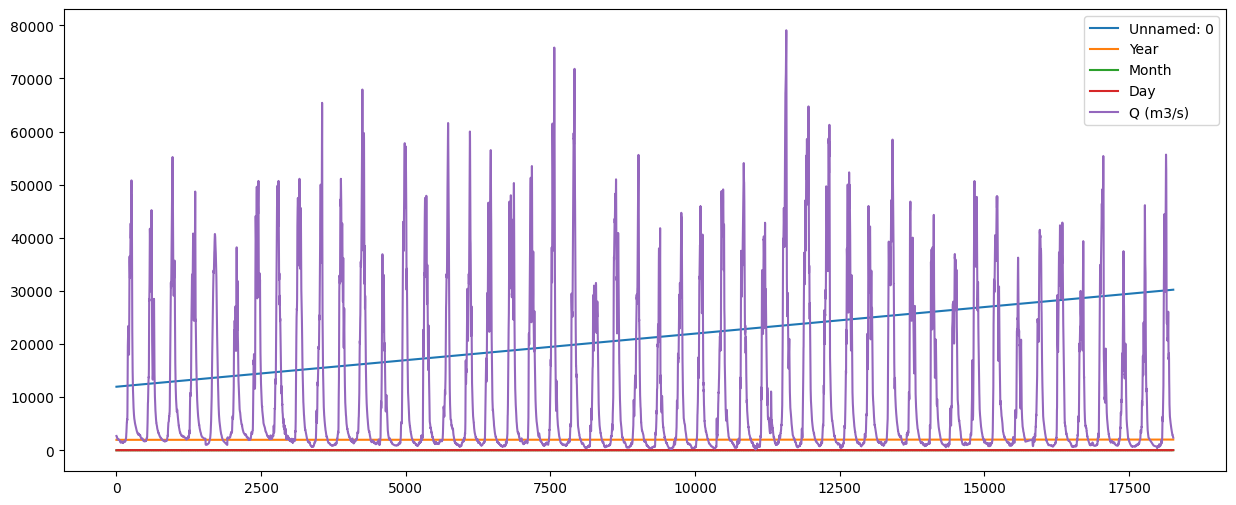

In [5]:
dftrain.info()

dftrain.plot()

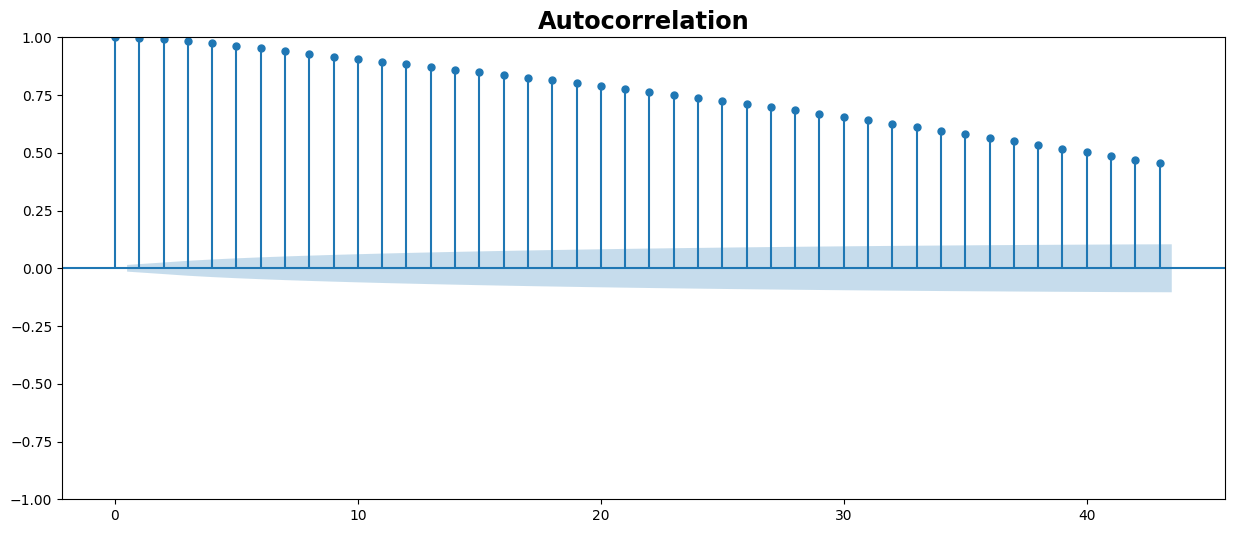

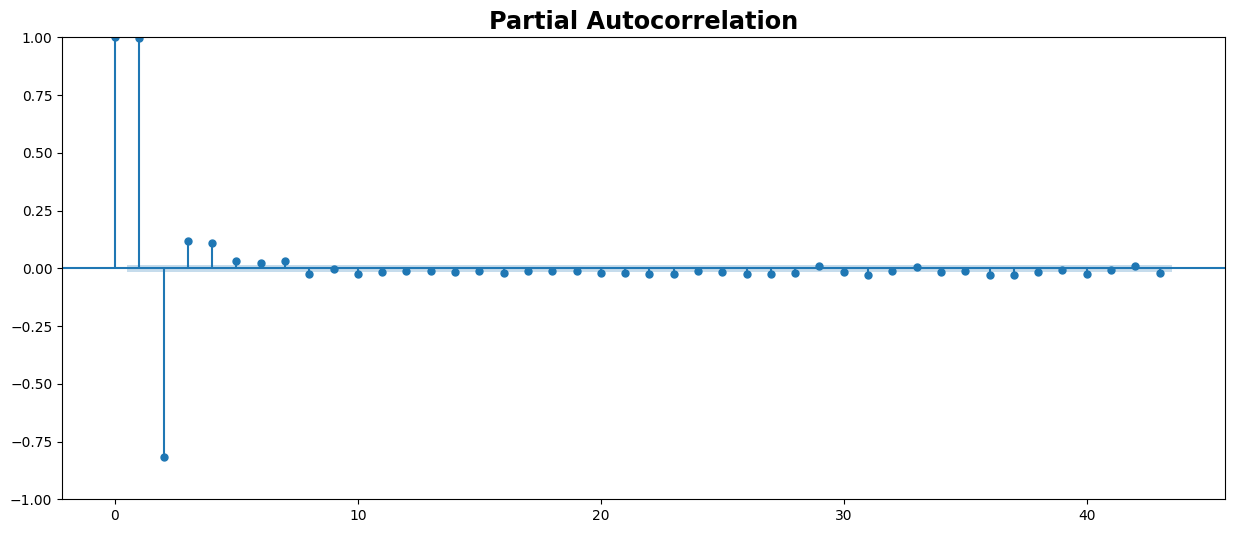

In [6]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf = plot_acf(dftrain['Q (m3/s)'])
pacf = plot_pacf(dftrain['Q (m3/s)'])

In [7]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(dftrain['Q (m3/s)'])
print(f'p-value: {adf_test[1]}' )

p-value: 4.739256943796087e-28


In [8]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(dftrain['Q (m3/s)'], order=(1,0,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:               Q (m3/s)   No. Observations:                18263
Model:                 ARIMA(1, 0, 1)   Log Likelihood             -144301.675
Date:                Mon, 20 Oct 2025   AIC                         288611.350
Time:                        21:50:09   BIC                         288642.601
Sample:                             0   HQIC                        288621.620
                              - 18263                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.068e+04     24.067    443.791      0.000    1.06e+04    1.07e+04
ar.L1          0.9985      0.000   3222.369      0.000       0.998       0.999
ma.L1          0.6837      0.002    371.209      0.0

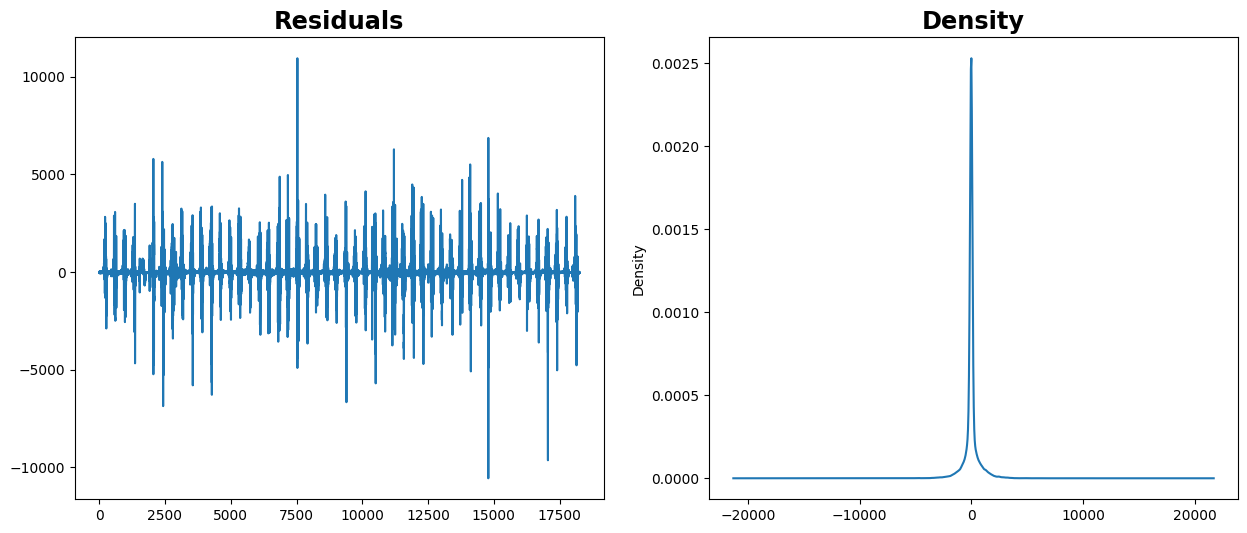

In [9]:
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1, 2)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()

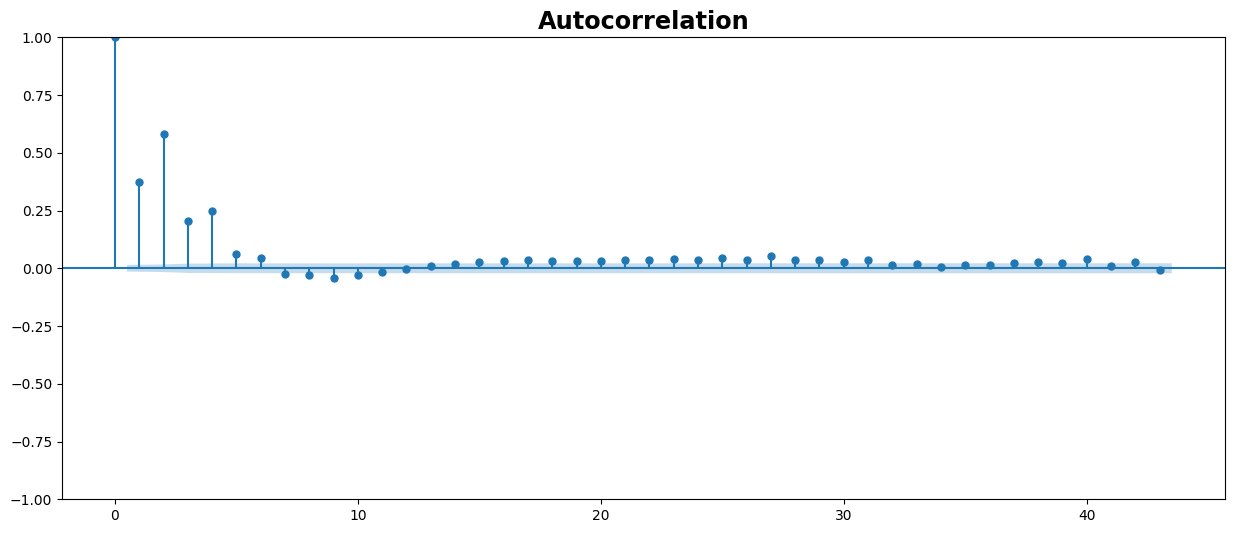

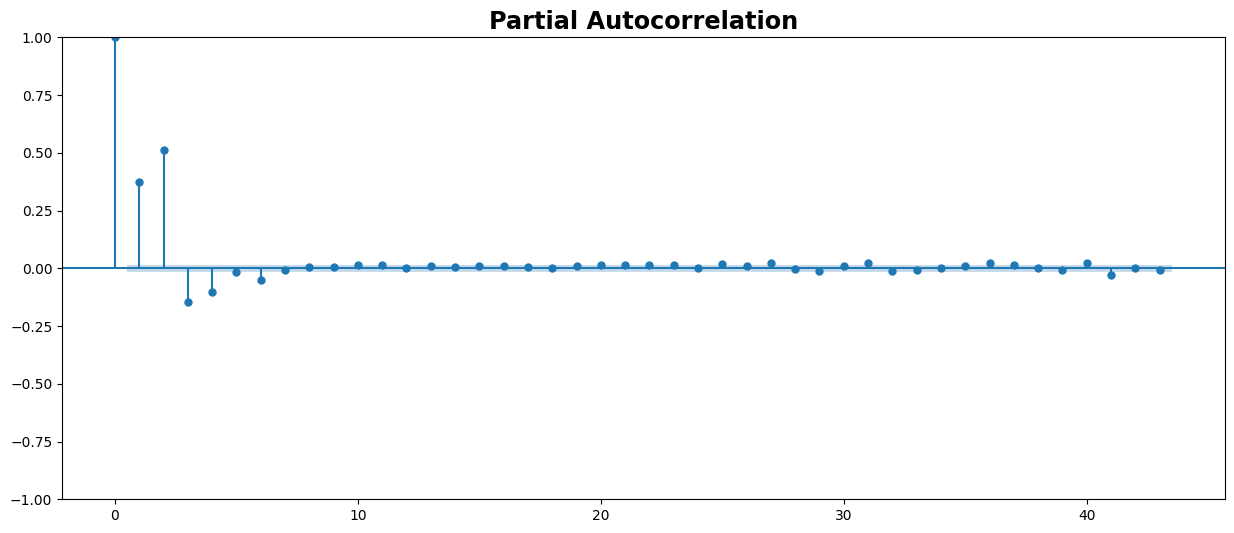

In [10]:
acf_res = plot_acf(residuals)

pacf_res = plot_pacf(residuals)

<Axes: >

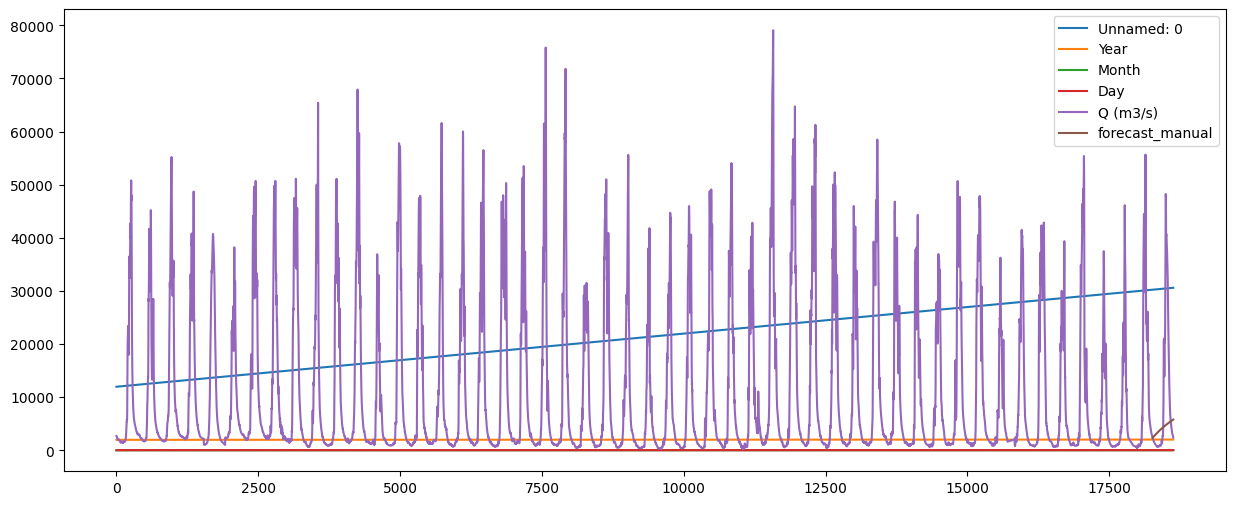

In [11]:
forecast_test = model_fit.forecast(len(dftest))
df['forecast_manual'] = [None]*len(dftrain) + list(forecast_test)
df.plot()

In [12]:
import pmdarima as pm
auto_arima = pm.auto_arima(dftrain['Q (m3/s)'], stepwise = False, seasonal=False)
auto_arima

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12

ARIMA(order=(4, 0, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [13]:
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                18263
Model:               SARIMAX(4, 0, 1)   Log Likelihood             -139827.167
Date:                Mon, 20 Oct 2025   AIC                         279666.334
Time:                        21:55:33   BIC                         279713.210
Sample:                             0   HQIC                        279681.739
                              - 18263                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.3053      0.028     81.992      0.000       2.250       2.360
ar.L2         -1.7068      0.055    -30.838      0.000      -1.815      -1.598
ar.L3          0.3469      0.032     10.691      0.000       0.283       0.410
ar.L4          0.0536      0.006      9.589      0.000       0.043       0.065
ma.L1         -0.3857      0.028    -13.617      0.000      -0.441      -0.330
sigma2       2.62e+05    566.506    462.495      0.000    2.61e+05    2.63e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):           2131958.33
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               1.21   Skew:                             0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                        55.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


<Axes: >

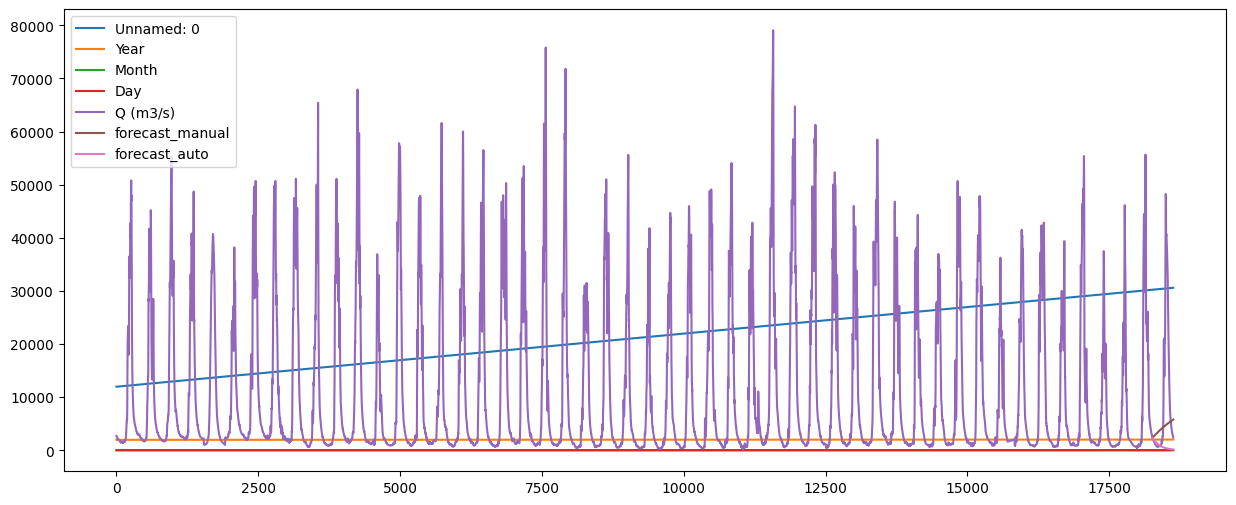

In [14]:
forecast_test_auto = auto_arima.predict(n_periods=len(dftest))
df['forecast_auto'] = [None]*len(dftrain) + list(forecast_test_auto)
df.plot()

In [16]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

mae = mean_absolute_error(dftest['Q (m3/s)'], forecast_test)
mape = mean_absolute_percentage_error(dftest['Q (m3/s)'], forecast_test)
mse = np.sqrt(mean_squared_error(dftest['Q (m3/s)'], forecast_test))

print(f'mae(manual): {mae}')
print(f'mape(manual): {mape}')
print(f'mse(manual): {mse}')

mae(manual): 8074.246449086609
mape(manual): 1.4467266560932897
mse(manual): 13703.19323696755


In [17]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

mae = mean_absolute_error(dftest['Q (m3/s)'], forecast_test_auto)
mape = mean_absolute_percentage_error(dftest['Q (m3/s)'], forecast_test_auto)
mse = np.sqrt(mean_squared_error(dftest['Q (m3/s)'], forecast_test_auto))

print(f'mae(auto): {mae}')
print(f'mape(auto): {mape}')
print(f'mse(auto): {mse}')

mae(auto): 9105.744024804906
mape(auto): 0.6846927078830347
mse(auto): 15949.374665328216
